In [18]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn import tree

import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
!pip install tensorflow

In [3]:
!pip install mlxtend

In [4]:
# FILE IMPORT
df = pd.read_excel('recruitment_data - 2.xlsx')
df.head()

,Age,GroupAge,Gender,EducationLevel,ExperienceYears,FirstJob,GroupYOE,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,G[20-27],1,L2,0,1,Y[0],3,26.783828,48,78,91,S1,1
1,39,G[28-40],1,L4,12,0,Y[11-15],3,25.862694,35,68,80,S2,1
2,48,G[41-50],0,L2,3,0,Y[1-5],2,9.920805,20,67,13,S2,0
3,34,G[28-40],1,L2,5,0,Y[1-5],2,6.407751,36,27,70,S3,0
4,30,G[28-40],0,L1,6,0,Y[6-10],1,43.105343,23,52,85,S2,0


In [5]:
# STAT EXPLORE

print("Dataset shape:", df.shape)
df.info()

print("\nDescriptive statistics:")
print(df.describe())

categorical_vars = ['Gender', 'EducationLevel', 'RecruitmentStrategy', 'HiringDecision']
for var in categorical_vars:
    print(f"\nUnique values in {var}: {df[var].unique()}")


Dataset shape: (1500, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1500 non-null   int64  
 1   GroupAge             1500 non-null   object 
 2   Gender               1500 non-null   int64  
 3   EducationLevel       1500 non-null   object 
 4   ExperienceYears      1500 non-null   int64  
 5   FirstJob             1500 non-null   int64  
 6   GroupYOE             1500 non-null   object 
 7   PreviousCompanies    1500 non-null   int64  
 8   DistanceFromCompany  1500 non-null   float64
 9   InterviewScore       1500 non-null   int64  
 10  SkillScore           1500 non-null   int64  
 11  PersonalityScore     1500 non-null   int64  
 12  RecruitmentStrategy  1500 non-null   object 
 13  HiringDecision       1500 non-null   int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 164.2+ KB

De

In [6]:
# GROUP DATA

# Age group
def group_age(age):
    if 20 <= age <= 27:
        return 'G[20-27]'
    elif 28 <= age <= 40:
        return 'G[28-40]'
    elif 41 <= age <= 50:
        return 'G[41-50]'
    else:
        return 'Other'

df['GroupAge'] = df['Age'].apply(group_age)

# Experience group
def group_yoe(yoe):
    if yoe == 0:
        return 'Y[0]'
    elif 1 <= yoe <= 5:
        return 'Y[1-5]'
    elif 6 <= yoe <= 10:
        return 'Y[6-10]'
    elif 11 <= yoe <= 15:
        return 'Y[11-15]'
    else:
        return 'Other'

df['GroupYOE'] = df['ExperienceYears'].apply(group_yoe)
df['FirstJob'] = (df['ExperienceYears'] == 0).astype(int)
df['REP_EducationLevel'] = df['EducationLevel'].replace({1: 'L1L2', 2: 'L1L2', 3: 'L3', 4: 'L4'})

df[['Age', 'GroupAge', 'ExperienceYears', 'GroupYOE', 'FirstJob', 'EducationLevel', 'REP_EducationLevel']].head()

print("GroupAge:", df['GroupAge'].unique())
print("GroupYOE:", df['GroupYOE'].unique())
print("REP_EducationLevel:", df['REP_EducationLevel'].unique())

GroupAge: ['G[20-27]' 'G[28-40]' 'G[41-50]']
GroupYOE: ['Y[0]' 'Y[11-15]' 'Y[1-5]' 'Y[6-10]']
REP_EducationLevel: ['L2' 'L4' 'L1' 'L3']


In [7]:
# DATA PARTITION

df_tr, df_va = train_test_split(df, test_size=0.5, random_state=123, stratify=df['HiringDecision'])

print("Training set shape:", df_tr.shape)
print("Validation set shape:", df_va.shape)

Training set shape: (750, 15)
Validation set shape: (750, 15)


In [8]:
# MAXIMAL TREE

features = ['InterviewScore', 'SkillScore', 'PersonalityScore', 'DistanceFromCompany', 'PreviousCompanies']
df_encoded = pd.get_dummies(df, columns=['GroupAge', 'GroupYOE', 'REP_EducationLevel', 'RecruitmentStrategy'], drop_first=True)
features += [col for col in df_encoded.columns if col.startswith(('GroupAge_', 'GroupYOE_', 'REP_EducationLevel_', 'RecruitmentStrategy_'))]
df_tr_encoded = df_encoded.loc[df_tr.index]
df_va_encoded = df_encoded.loc[df_va.index]

X_train = df_tr_encoded[features]
y_train = df_tr_encoded['HiringDecision']
X_val = df_va_encoded[features]
y_val = df_va_encoded['HiringDecision']

max_tree = DecisionTreeClassifier(random_state=42)
max_tree.fit(X_train, y_train)

y_pred_max = max_tree.predict_proba(X_val)[:, 1]
ase_max = mean_squared_error(y_val, y_pred_max)
print("Maximal Tree ASE:", ase_max)
print("Maximal Tree number of leaves:", max_tree.get_n_leaves())

Maximal Tree ASE: 0.17733333333333334
Maximal Tree number of leaves: 99


In [9]:
# ASE TREE

ase_results = []

for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    ase = mean_squared_error(y_val, y_pred)
    ase_results.append((depth, ase, model.get_n_leaves()))

best_ase = min(ase_results, key=lambda x: x[1])
print(f"ASE Tree - Best depth: {best_ase[0]}, ASE: {best_ase[1]}, Leaves: {best_ase[2]}")

ASE Tree - Best depth: 5, ASE: 0.13021159870040222, Leaves: 27


In [10]:
# MISSCLASSIFICATION TREE

miss_results = []

for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    error = 1 - accuracy_score(y_val, y_pred)
    miss_results.append((depth, error, model.get_n_leaves()))

best_miss = min(miss_results, key=lambda x: x[1])
print(f"Misclassification Tree - Best depth: {best_miss[0]}, Error Rate: {best_miss[1]}, Leaves: {best_miss[2]}")

Misclassification Tree - Best depth: 5, Error Rate: 0.15466666666666662, Leaves: 27


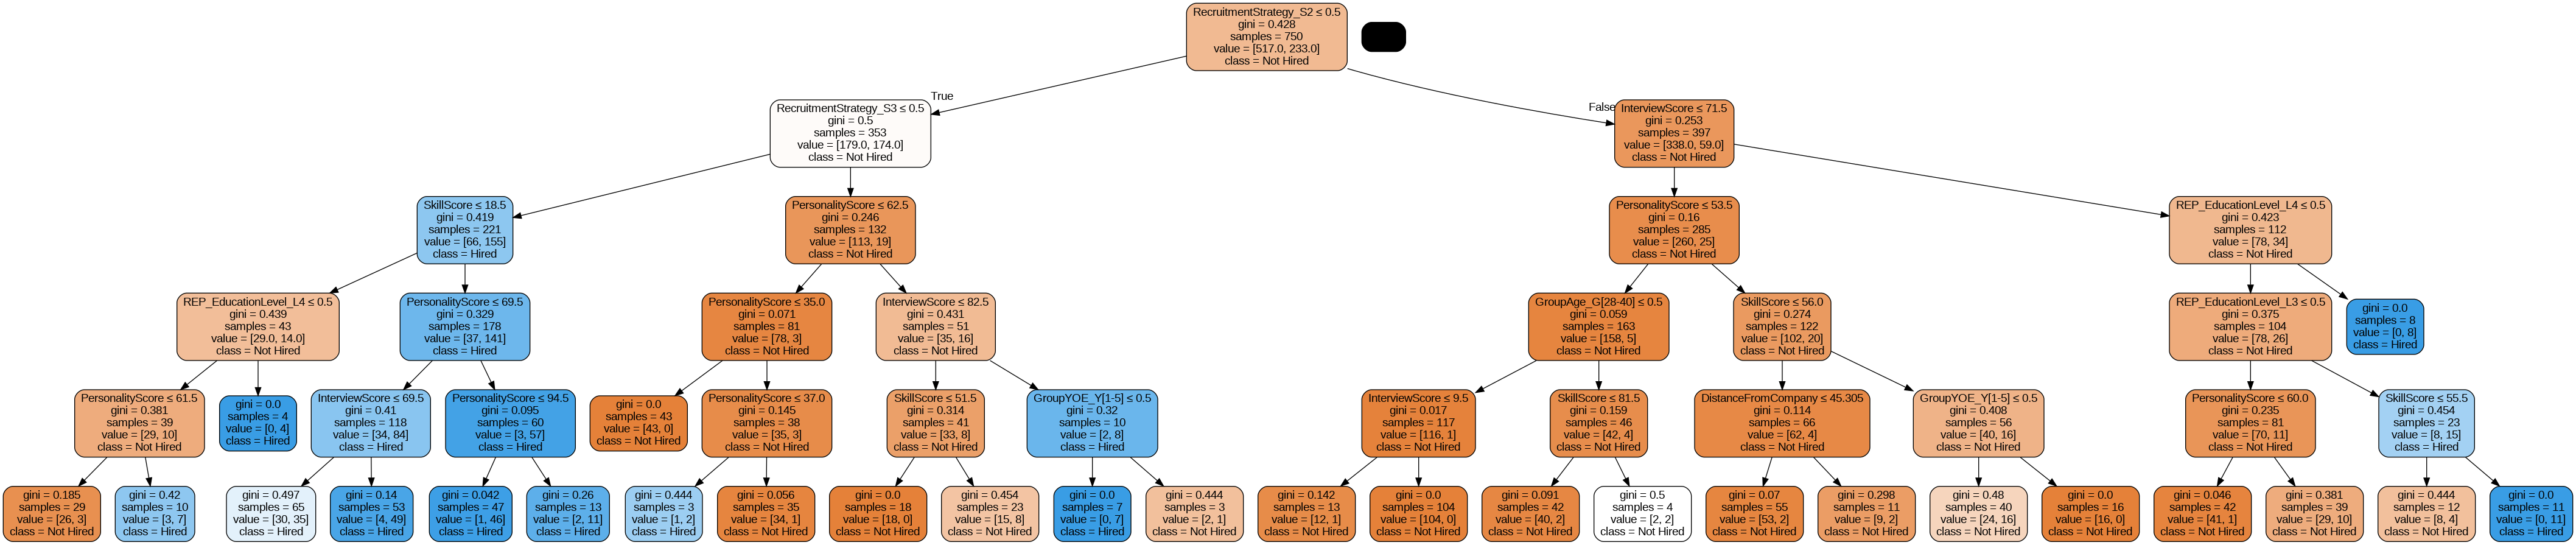

In [11]:
# VISUALIZE BEST TREE

best_depth = best_ase[0]
best_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_tree.fit(X_train, y_train)

dot_data = tree.export_graphviz(best_tree, out_file=None, feature_names=features, class_names=['Not Hired', 'Hired'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [12]:
# RECODE DUMMIES

df_encoded = df.copy()

categorical_vars = ['GroupAge', 'GroupYOE', 'REP_EducationLevel', 'RecruitmentStrategy']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_vars, drop_first=True)

if 'EducationLevel' in df_encoded.columns:
    df_encoded.drop('EducationLevel', axis=1, inplace=True)

print(df_encoded.columns)


df_tr, df_va = train_test_split(df_encoded, test_size=0.5, random_state=42, stratify=df_encoded['HiringDecision'])

X_train = df_tr.drop('HiringDecision', axis=1)
y_train = df_tr['HiringDecision']
X_val = df_va.drop('HiringDecision', axis=1)
y_val = df_va['HiringDecision']

Index(['Age', 'Gender', 'ExperienceYears', 'FirstJob', 'PreviousCompanies',
       'DistanceFromCompany', 'InterviewScore', 'SkillScore',
       'PersonalityScore', 'HiringDecision', 'GroupAge_G[28-40]',
       'GroupAge_G[41-50]', 'GroupYOE_Y[1-5]', 'GroupYOE_Y[11-15]',
       'GroupYOE_Y[6-10]', 'REP_EducationLevel_L2', 'REP_EducationLevel_L3',
       'REP_EducationLevel_L4', 'RecruitmentStrategy_S2',
       'RecruitmentStrategy_S3'],
      dtype='object')


In [19]:
# FULL REGRESSION

model_full = LogisticRegression(max_iter=1000, solver='liblinear')
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict_proba(X_val)[:, 1]

ase_full = mean_squared_error(y_val, y_pred_full)
roc_full = roc_auc_score(y_val, y_pred_full)
print(f"Full Logistic Regression - ASE: {ase_full:.6f}, ROC AUC: {roc_full:.4f}")

Full Logistic Regression - ASE: 0.090305, ROC AUC: 0.9054


In [20]:
#FORWARD REGRESSION

forward_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'), k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', cv=5)

forward_selector = forward_selector.fit(X_train, y_train)
selected_forward = list(forward_selector.k_feature_names_)
print("Forward selected features:", selected_forward)


model_fwd = LogisticRegression(max_iter=1000, solver='liblinear')
model_fwd.fit(X_train[selected_forward], y_train)
y_pred_fwd = model_fwd.predict_proba(X_val[selected_forward])[:, 1]
ase_fwd = mean_squared_error(y_val, y_pred_fwd)

Forward selected features: ['Age', 'Gender', 'ExperienceYears', 'FirstJob', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'GroupYOE_Y[1-5]', 'REP_EducationLevel_L3', 'REP_EducationLevel_L4', 'RecruitmentStrategy_S2', 'RecruitmentStrategy_S3']


In [29]:
# ODDS FORWARD REGRESSION

X_train_fwd_const = sm.add_constant(X_train[selected_forward].astype(float))

logit_fwd = sm.Logit(y_train, X_train_fwd_const)
result_fwd = logit_fwd.fit()

odds_fwd = pd.DataFrame({
    'Variable': result_fwd.params.index,
    'Coef': result_fwd.params.values,
    'Odds Ratio': np.exp(result_fwd.params.values),
    'p-value': result_fwd.pvalues
})
print("Odds Ratios – Forward Regression")
print(odds_fwd)

def interpret_odds(row):
    var = row['Variable']
    or_value = row['Odds Ratio']
    if var == 'const':
        return "Baseline (intercept)"
    elif or_value > 1:
        return f"↑ A 1-unit increase in {var} increases the odds of being hired by {((or_value - 1) * 100):.1f}%"
    else:
        return f"↓ A 1-unit increase in {var} decreases the odds of being hired by {((1 - or_value) * 100):.1f}%"

odds_fwd['Interpretation'] = odds_fwd.apply(interpret_odds, axis=1)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

print("Odds Ratios – Forward Regression")
print(odds_fwd[['Variable', 'Odds Ratio', 'Interpretation']])

Optimization terminated successfully.
         Current function value: 0.272190
         Iterations 8
Odds Ratios – Forward Regression
                                      Variable      Coef  Odds Ratio  \
const                                    const -2.443784    0.086832   
Age                                        Age -0.007726    0.992304   
Gender                                  Gender  0.034589    1.035194   
ExperienceYears                ExperienceYears -0.094201    0.910100   
FirstJob                              FirstJob -3.811567    0.022114   
PreviousCompanies            PreviousCompanies  0.163743    1.177912   
DistanceFromCompany        DistanceFromCompany -0.019593    0.980598   
InterviewScore                  InterviewScore  0.034390    1.034988   
SkillScore                          SkillScore  0.044416    1.045418   
PersonalityScore              PersonalityScore  0.030366    1.030832   
GroupYOE_Y[1-5]                GroupYOE_Y[1-5] -3.027550    0.048434   
R

In [30]:
#BACKWARD REGRESSION

backward_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'), k_features='best', forward=False, floating=False, scoring='neg_mean_squared_error', cv=5)

backward_selector = backward_selector.fit(X_train, y_train)
selected_backward = list(backward_selector.k_feature_names_)
print("Backward selected features:", selected_backward)

model_bwd = LogisticRegression(max_iter=1000, solver='liblinear')
model_bwd.fit(X_train[selected_backward], y_train)
y_pred_bwd = model_bwd.predict_proba(X_val[selected_backward])[:, 1]
ase_bwd = mean_squared_error(y_val, y_pred_bwd)

Backward selected features: ['Age', 'Gender', 'FirstJob', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'GroupAge_G[28-40]', 'GroupAge_G[41-50]', 'GroupYOE_Y[1-5]', 'GroupYOE_Y[6-10]', 'REP_EducationLevel_L3', 'REP_EducationLevel_L4', 'RecruitmentStrategy_S2', 'RecruitmentStrategy_S3']


In [31]:
# ODDS BACKWARD REGRESSION
X_train_bwd_const = sm.add_constant(X_train[selected_backward].astype(float))

logit_bwd = sm.Logit(y_train, X_train_bwd_const)
result_bwd = logit_bwd.fit()

odds_bwd = pd.DataFrame({
    'Variable': result_bwd.params.index,
    'Coefficient': result_bwd.params.values,
    'Odds Ratio': np.exp(result_bwd.params.values),
    'p-value': result_bwd.pvalues
})


def interpret_odds(row):
    var = row['Variable']
    or_value = row['Odds Ratio']
    if var == 'const':
        return "Baseline (intercept)"
    elif or_value > 1:
        return f"↑ A 1-unit increase in {var} increases the odds of being hired by {((or_value - 1) * 100):.1f}%"
    else:
        return f"↓ A 1-unit increase in {var} decreases the odds of being hired by {((1 - or_value) * 100):.1f}%"

odds_bwd['Interpretation'] = odds_bwd.apply(interpret_odds, axis=1)


pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

print("Odds Ratios – Backward Regression")
print(odds_bwd[['Variable', 'Odds Ratio', 'Interpretation']])

Optimization terminated successfully.
         Current function value: 0.270178
         Iterations 8
Odds Ratios – Backward Regression
                                      Variable  Odds Ratio  \
const                                    const    0.069798   
Age                                        Age    0.940509   
Gender                                  Gender    1.088876   
FirstJob                              FirstJob    0.087752   
PreviousCompanies            PreviousCompanies    1.195699   
DistanceFromCompany        DistanceFromCompany    0.980341   
InterviewScore                  InterviewScore    1.034110   
SkillScore                          SkillScore    1.045630   
PersonalityScore              PersonalityScore    1.030903   
GroupAge_G[28-40]            GroupAge_G[28-40]    2.124123   
GroupAge_G[41-50]            GroupAge_G[41-50]    4.007510   
GroupYOE_Y[1-5]                GroupYOE_Y[1-5]    0.134114   
GroupYOE_Y[6-10]              GroupYOE_Y[6-10]    1.928979

In [32]:
#STEPWISE REGRESSION

stepwise_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'), k_features='best', forward=True, floating=True, scoring='neg_mean_squared_error', cv=5)

stepwise_selector = stepwise_selector.fit(X_train, y_train)
selected_stepwise = list(stepwise_selector.k_feature_names_)
print("Stepwise selected features:", selected_stepwise)

model_step = LogisticRegression(max_iter=1000, solver='liblinear')
model_step.fit(X_train[selected_stepwise], y_train)
y_pred_step = model_step.predict_proba(X_val[selected_stepwise])[:, 1]
ase_step = mean_squared_error(y_val, y_pred_step)

Stepwise selected features: ['Age', 'Gender', 'FirstJob', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'GroupAge_G[28-40]', 'GroupAge_G[41-50]', 'GroupYOE_Y[1-5]', 'GroupYOE_Y[6-10]', 'REP_EducationLevel_L3', 'REP_EducationLevel_L4', 'RecruitmentStrategy_S2', 'RecruitmentStrategy_S3']


In [33]:
# ODDS STEPWISE REGRESSION
X_train_step_const = sm.add_constant(X_train[selected_stepwise].astype(float))

logit_step = sm.Logit(y_train, X_train_step_const)
result_step = logit_step.fit()

odds_step = pd.DataFrame({
    'Variable': result_step.params.index,
    'Coefficient': result_step.params.values,
    'Odds Ratio': np.exp(result_step.params.values),
    'p-value': result_step.pvalues
})

odds_step['Interpretation'] = odds_step.apply(interpret_odds, axis=1)

print("Odds Ratios – Stepwise Regression")
print(odds_step[['Variable', 'Odds Ratio', 'Interpretation']])

Optimization terminated successfully.
         Current function value: 0.270178
         Iterations 8
Odds Ratios – Stepwise Regression
                                      Variable  Odds Ratio  \
const                                    const    0.069798   
Age                                        Age    0.940509   
Gender                                  Gender    1.088876   
FirstJob                              FirstJob    0.087752   
PreviousCompanies            PreviousCompanies    1.195699   
DistanceFromCompany        DistanceFromCompany    0.980341   
InterviewScore                  InterviewScore    1.034110   
SkillScore                          SkillScore    1.045630   
PersonalityScore              PersonalityScore    1.030903   
GroupAge_G[28-40]            GroupAge_G[28-40]    2.124123   
GroupAge_G[41-50]            GroupAge_G[41-50]    4.007510   
GroupYOE_Y[1-5]                GroupYOE_Y[1-5]    0.134114   
GroupYOE_Y[6-10]              GroupYOE_Y[6-10]    1.928979

In [34]:
# NN FOR FORWARD, BACKWARD AND STEPWISE

def train_nn_with_features(X_train, y_train, X_val, y_val, features, label):
    model = Sequential()
    model.add(Dense(6, activation='relu', input_shape=(len(features),)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='binary_crossentropy')

    model.fit(X_train[features], y_train,
              epochs=100,
              batch_size=32,
              verbose=0,
              validation_data=(X_val[features], y_val))

    y_pred = model.predict(X_val[features]).flatten()
    ase = mean_squared_error(y_val, y_pred)
    print(f"{label} - ASE: {ase:.6f}")
    return ase

In [35]:
# NN FORWARD REGRESSION
ase_nn_fwd = train_nn_with_features(X_train, y_train, X_val, y_val, selected_forward, "NN Forward Regression")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
NN Forward Regression - ASE: 0.140898


In [36]:
# NN BACKWARD REGRESSION
ase_nn_bwd = train_nn_with_features(X_train, y_train, X_val, y_val, selected_backward, "NN Backward Regression")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
NN Backward Regression - ASE: 0.106578


In [37]:
# NN STEPWISE REGRESSION
ase_nn_step = train_nn_with_features(X_train, y_train, X_val, y_val, selected_stepwise, "NN Stepwise Regression")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
NN Stepwise Regression - ASE: 0.096262


In [38]:
# 2N, 3N, 4N, 5N, 6N, 7N, 8N NEURAL NETWORK

X_nn_train = df_tr.drop('HiringDecision', axis=1)
y_nn_train = df_tr['HiringDecision']
X_nn_val = df_va.drop('HiringDecision', axis=1)
y_nn_val = df_va['HiringDecision']

nn_results = []

for n in range(2, 9):
    model = Sequential()
    model.add(Dense(n, activation='relu', input_shape=(X_nn_train.shape[1],)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy')

    model.fit(X_nn_train, y_nn_train, epochs=100, batch_size=32, verbose=0)

    y_pred = model.predict(X_nn_val).flatten()
    ase = mean_squared_error(y_nn_val, y_pred)
    nn_results.append((f"{n}N", ase))
    print(f"{n}N Neural Network - ASE: {ase:.6f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2N Neural Network - ASE: 0.098198


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3N Neural Network - ASE: 0.090059


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4N Neural Network - ASE: 0.092419


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5N Neural Network - ASE: 0.092519


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6N Neural Network - ASE: 0.087943


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7N Neural Network - ASE: 0.121491


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8N Neural Network - ASE: 0.113263


In [39]:
# 2N, 3N, 4N, 5N, 6N, 7N, 8N NEURAL NETWORK - PRE TRAINING

pt_results = []

for n in range(2, 9):
    model = Sequential()
    model.add(Dense(n, activation='relu', input_shape=(X_nn_train.shape[1],)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy')

    # Pre-training (warm-up): 10 epochs
    model.fit(X_nn_train, y_nn_train, epochs=10, batch_size=32, verbose=0)

    # Fine-tune: additional 90 epochs
    model.fit(X_nn_train, y_nn_train, epochs=90, batch_size=32, verbose=0)

    y_pred = model.predict(X_nn_val).flatten()
    ase = mean_squared_error(y_nn_val, y_pred)
    pt_results.append((f"{n}N_PT_Y", ase))
    print(f"{n}N_PT_Y Neural Network - ASE: {ase:.6f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2N_PT_Y Neural Network - ASE: 0.093239


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3N_PT_Y Neural Network - ASE: 0.096732


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4N_PT_Y Neural Network - ASE: 0.100404


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5N_PT_Y Neural Network - ASE: 0.104505


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6N_PT_Y Neural Network - ASE: 0.096944


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7N_PT_Y Neural Network - ASE: 0.097573


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8N_PT_Y Neural Network - ASE: 0.092917


In [40]:
# NN DATA PARTITION
model_dp = Sequential()
model_dp.add(Dense(6, activation='relu', input_shape=(X_nn_train.shape[1],)))
model_dp.add(Dense(1, activation='sigmoid'))
model_dp.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy')
model_dp.fit(X_nn_train, y_nn_train, epochs=100, batch_size=32, verbose=0)
y_pred_dp = model_dp.predict(X_nn_val).flatten()
ase_dp = mean_squared_error(y_nn_val, y_pred_dp)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [41]:
## NN DATA PARTITION - PRE TRAINING
model_dp_pt = Sequential()
model_dp_pt.add(Dense(6, activation='relu', input_shape=(X_nn_train.shape[1],)))
model_dp_pt.add(Dense(1, activation='sigmoid'))
model_dp_pt.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy')
model_dp_pt.fit(X_nn_train, y_nn_train, epochs=10, batch_size=32, verbose=0)
model_dp_pt.fit(X_nn_train, y_nn_train, epochs=90, batch_size=32, verbose=0)
y_pred_dp_pt = model_dp_pt.predict(X_nn_val).flatten()
ase_dp_pt = mean_squared_error(y_nn_val, y_pred_dp_pt)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [42]:
# NN RECODE DUMMIES

ase_recode_dummies = ase_dp
ase_recode_dummies_pt = ase_dp_pt

In [43]:
## NN FORWARD REGRESSION - PRE TRAINING

model_fwd_pt = Sequential()
model_fwd_pt.add(Dense(6, activation='relu', input_shape=(len(selected_forward),)))
model_fwd_pt.add(Dense(1, activation='sigmoid'))
model_fwd_pt.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy')
model_fwd_pt.fit(X_train[selected_forward], y_train, epochs=10, batch_size=32, verbose=0)
model_fwd_pt.fit(X_train[selected_forward], y_train, epochs=90, batch_size=32, verbose=0)
y_pred_fwd_pt = model_fwd_pt.predict(X_val[selected_forward]).flatten()
ase_fwd_pt = mean_squared_error(y_val, y_pred_fwd_pt)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [44]:
## NN BACKWARD REGRESSION - PRE TRAINING

model_bwd_pt = Sequential()
model_bwd_pt.add(Dense(6, activation='relu', input_shape=(len(selected_backward),)))
model_bwd_pt.add(Dense(1, activation='sigmoid'))
model_bwd_pt.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy')
model_bwd_pt.fit(X_train[selected_backward], y_train, epochs=10, batch_size=32, verbose=0)
model_bwd_pt.fit(X_train[selected_backward], y_train, epochs=90, batch_size=32, verbose=0)
y_pred_bwd_pt = model_bwd_pt.predict(X_val[selected_backward]).flatten()
ase_bwd_pt = mean_squared_error(y_val, y_pred_bwd_pt)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [45]:
## NN STEPWISE - PRE TRAINING

model_step_pt = Sequential()
model_step_pt.add(Dense(6, activation='relu', input_shape=(len(selected_stepwise),)))
model_step_pt.add(Dense(1, activation='sigmoid'))
model_step_pt.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy')
model_step_pt.fit(X_train[selected_stepwise], y_train, epochs=10, batch_size=32, verbose=0)
model_step_pt.fit(X_train[selected_stepwise], y_train, epochs=90, batch_size=32, verbose=0)
y_pred_step_pt = model_step_pt.predict(X_val[selected_stepwise]).flatten()
ase_step_pt = mean_squared_error(y_val, y_pred_step_pt)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [46]:
#MODEL COMPARISON

print("Final Model Comparison (sorted by ASE):")

extra_models = [("NN Data partition", ase_dp), ("NN Data partition PT_Y", ase_dp_pt), ("NN- Recode dummies", ase_recode_dummies), ("NN- Recode dummies PT_Y", ase_recode_dummies_pt),
                ("NN Forward reg PT_Y", ase_fwd_pt), ("NN Backward PT_Y", ase_bwd_pt), ("NN Stepwise reg PT_Y", ase_step_pt)]


all_models = nn_results + pt_results + extra_models + [
    ("NN Forward Regression", ase_nn_fwd),
    ("NN Backward Regression", ase_nn_bwd),
    ("NN Stepwise Regression", ase_nn_step),
    ("Full Logistic Regression", ase_full),
    ("Forward Logistic", ase_fwd),
    ("Backward Logistic", ase_bwd),
    ("Stepwise Logistic", ase_step),
    ("Maximal Tree", ase_max),
    ("ASE Tree", best_ase[1]),
    ("Misclassification Tree", best_miss[1]),
]

for name, ase in sorted(all_models, key=lambda x: x[1]):
    print(f"{name:30s}: ASE = {ase:.6f}")


Final Model Comparison (sorted by ASE):
NN Data partition PT_Y        : ASE = 0.086069
NN- Recode dummies PT_Y       : ASE = 0.086069
6N                            : ASE = 0.087943
Forward Logistic              : ASE = 0.089437
3N                            : ASE = 0.090059
Full Logistic Regression      : ASE = 0.090305
Backward Logistic             : ASE = 0.090419
Stepwise Logistic             : ASE = 0.090419
4N                            : ASE = 0.092419
5N                            : ASE = 0.092519
8N_PT_Y                       : ASE = 0.092917
2N_PT_Y                       : ASE = 0.093239
NN Stepwise Regression        : ASE = 0.096262
3N_PT_Y                       : ASE = 0.096732
6N_PT_Y                       : ASE = 0.096944
7N_PT_Y                       : ASE = 0.097573
2N                            : ASE = 0.098198
NN Backward PT_Y              : ASE = 0.098351
4N_PT_Y                       : ASE = 0.100404
5N_PT_Y                       : ASE = 0.104505
NN Backward Regressi